### Importing Libraries

In [94]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMean
import math
import pickle
import os
from xgboost import XGBClassifier
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

### Reading Data

In [24]:

from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

### Adding Feature  Preferential Attachment


 <b>Preferential Attachment </b> One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.





<img src="https://imgur.com/0i2qoMD.jpg">

In [28]:
def preferential_attachment(df_final):
    preferential_attachment_followers=[] # function for calculating  preferential_attachment
    preferential_attachment_followees=[]
    preferential_attachment_followers=df_final['num_followers_s']*df_final['num_followers_d']
    preferential_attachment_followees=df_final['num_followees_s']*df_final['num_followees_d']
    return preferential_attachment_followers,preferential_attachment_followees

In [109]:
 #adding the feature into both x_test and x_train
(df_final_train[' preferential_attachment_followers'], df_final_train['preferential_attachment_followees'])= preferential_attachment(df_final_train)
(df_final_test[' preferential_attachment_followers'], df_final_test['preferential_attachment_followees'])= preferential_attachment(df_final_test)
    

In [32]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [37]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [33]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [34]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [35]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


### Adding Feature svd_dot


 <b>svd_dot </b>  is the  Dot product between source node svd and destination node svd features

In [48]:
def np_dot(df_final):
    # function product between source node and destination of svd features
    np_dot_u=[]
    np_dot_v=[]
    for i,row in df_final.iterrows():
        a=svd(row['source_node'],U)
        b=svd(row['destination_node'],U)
        np_dot_u.append(np.dot(a,b))
        c=svd(row['source_node'],V.T)
        d=svd(row['destination_node'],V.T)
        np_dot_v.append(np.dot(c,d))
        
    return np_dot_u,np_dot_v           

In [51]:
(df_final_train['np_dot_u'],df_final_train['np_dot_v'])=np_dot(df_final_train)
(df_final_test['np_dot_u'],df_final_test['np_dot_v'])=np_dot(df_final_test)

In [110]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', ' preferential_attachment_followers',
       'preferential_attachment_followees', 'np_dot_u', 'np_dot_v'],
      dtype='object')

In [55]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [56]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.970206342244571 test Score 0.9311625734966357
Estimators =  50 Train Score 0.9839552802538148 test Score 0.9289288440335849
Estimators =  100 Train Score 0.9930318130320136 test Score 0.9183533741281185
Estimators =  150 Train Score 0.9985403211293514 test Score 0.9069797612869744
Estimators =  200 Train Score 0.9997601822614812 test Score 0.8960953878406709


Text(0.5,1,'Estimators vs score at depth of 5')

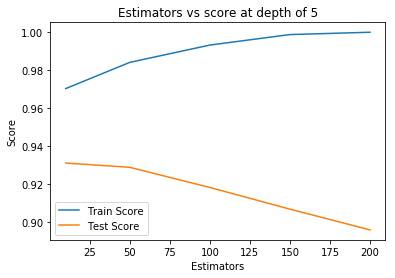

In [95]:
estimators = [10,50,100,150,200]
train_scores = []
test_scores = []
for i in estimators:
    clf =  XGBClassifier(n_estimators=i, n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9796490520371117 test Score 0.8945009292664262
depth =  9 Train Score 0.9999800195808108 test Score 0.9237517300117108
depth =  11 Train Score 1.0 test Score 0.9254175343164337
depth =  15 Train Score 1.0 test Score 0.9270393550440225
depth =  20 Train Score 1.0 test Score 0.9292501745994793


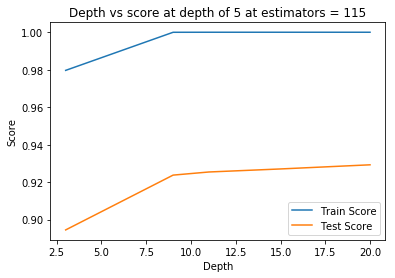

In [97]:
depths = [3,9,11,15,20]
train_scores = []
test_scores = []
for i in depths:
    clf =  XGBClassifier(max_depth=i, n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [98]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              'learning_rate': [0.1, 0.01, 0.05]
            }

clf =  XGBClassifier( n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=3,cv=3,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98027002 0.97432382 0.97266916]
mean train scores [0.99934022 0.98917069 0.97726836]


In [99]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [100]:
clf=rf_random.best_estimator_

In [101]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [102]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9984894713149604
Test f1 score 0.9269121331804476


In [103]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


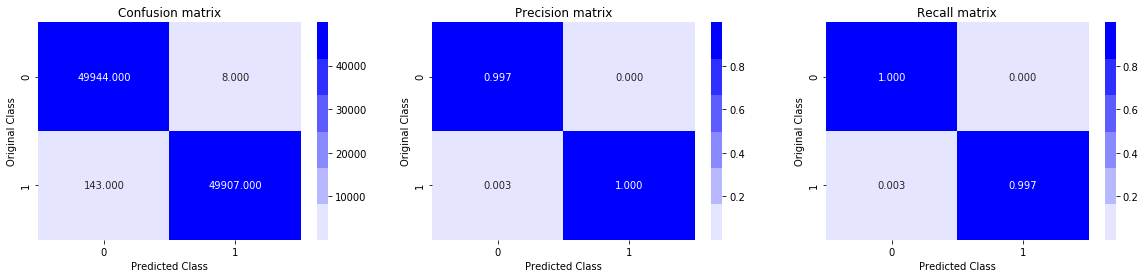

Test confusion_matrix


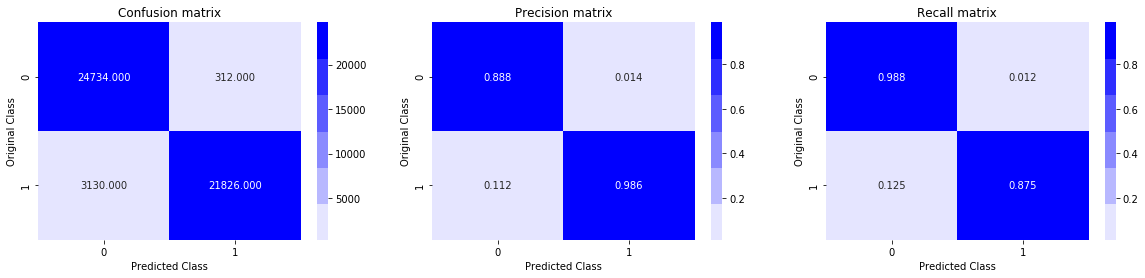

In [104]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

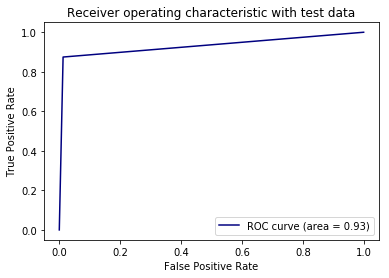

In [106]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

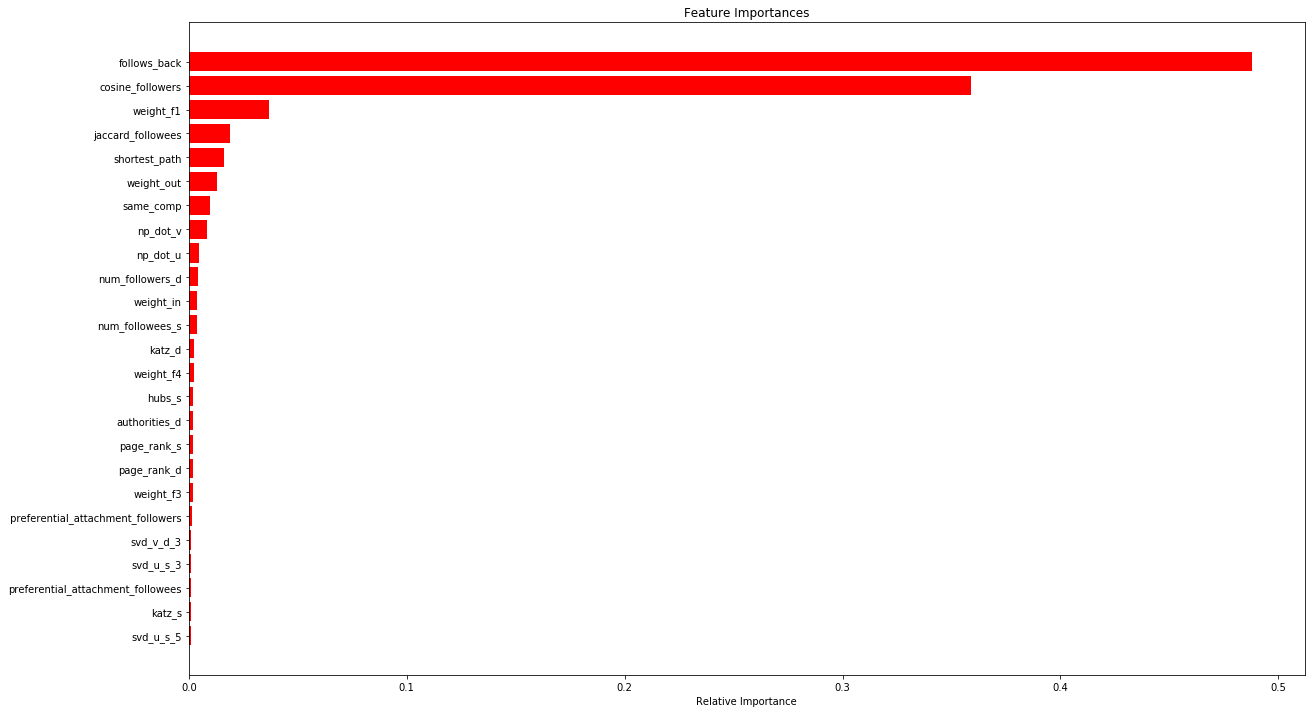

In [108]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* for xgboost modelling ,model is overfitting also there decrease in precision and recall for a class
* still follow back is the most important feature
* new added feature svd_dot have some on calssification